## 测量因子

In [1]:
import pandas as pd
import numpy as np

from Utility.factorFactory import FactorFactory
import matplotlib.pyplot as plt

from Utility.registry import FACTOR_REGISTRY

/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### （1）预处理数据：

In [2]:
df = pd.read_csv ('SPY_2020-07-01_2021-07-01_minute.csv')
df = df.head(1000)
df.shape

(1000, 17)

In [ ]:
df.columns

In [3]:
finfact = FactorFactory (df, forward_period=5, window=100, scaler='abs_minmax', top_k=100, use_disk_cache=True)

IO Dump: 100%|██████████| 16/16 [00:00<00:00, 2020.68it/s]
IO Dump: 0it [00:00, ?it/s]


In [ ]:
FACTOR_REGISTRY.keys()

In [4]:
finfact.generate_factors(mode='thread', bounded_only=True)

IO Wash:  15%|█▍        | 2885/19258 [00:02<00:12, 1307.90it/s, dropped=11]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IO Wash:  32%|███▏      | 6157/19258 [00:04<00:07, 1759.35it/s, dropped=26]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IO Wash:  42%|████▏     | 8129/19258 [00:06<00:09, 1149.85it/s, dropped=41]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change

### （3）评测因子：

In [ ]:
finfact.get_summary ()

In [ ]:
cur_features = finfact.next(k=10, mode='thread', bounded_only=True)

🔄 并行降维:   0%|          | 0/6 [00:00<?, ?it/s]/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
🔄 并行降维: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


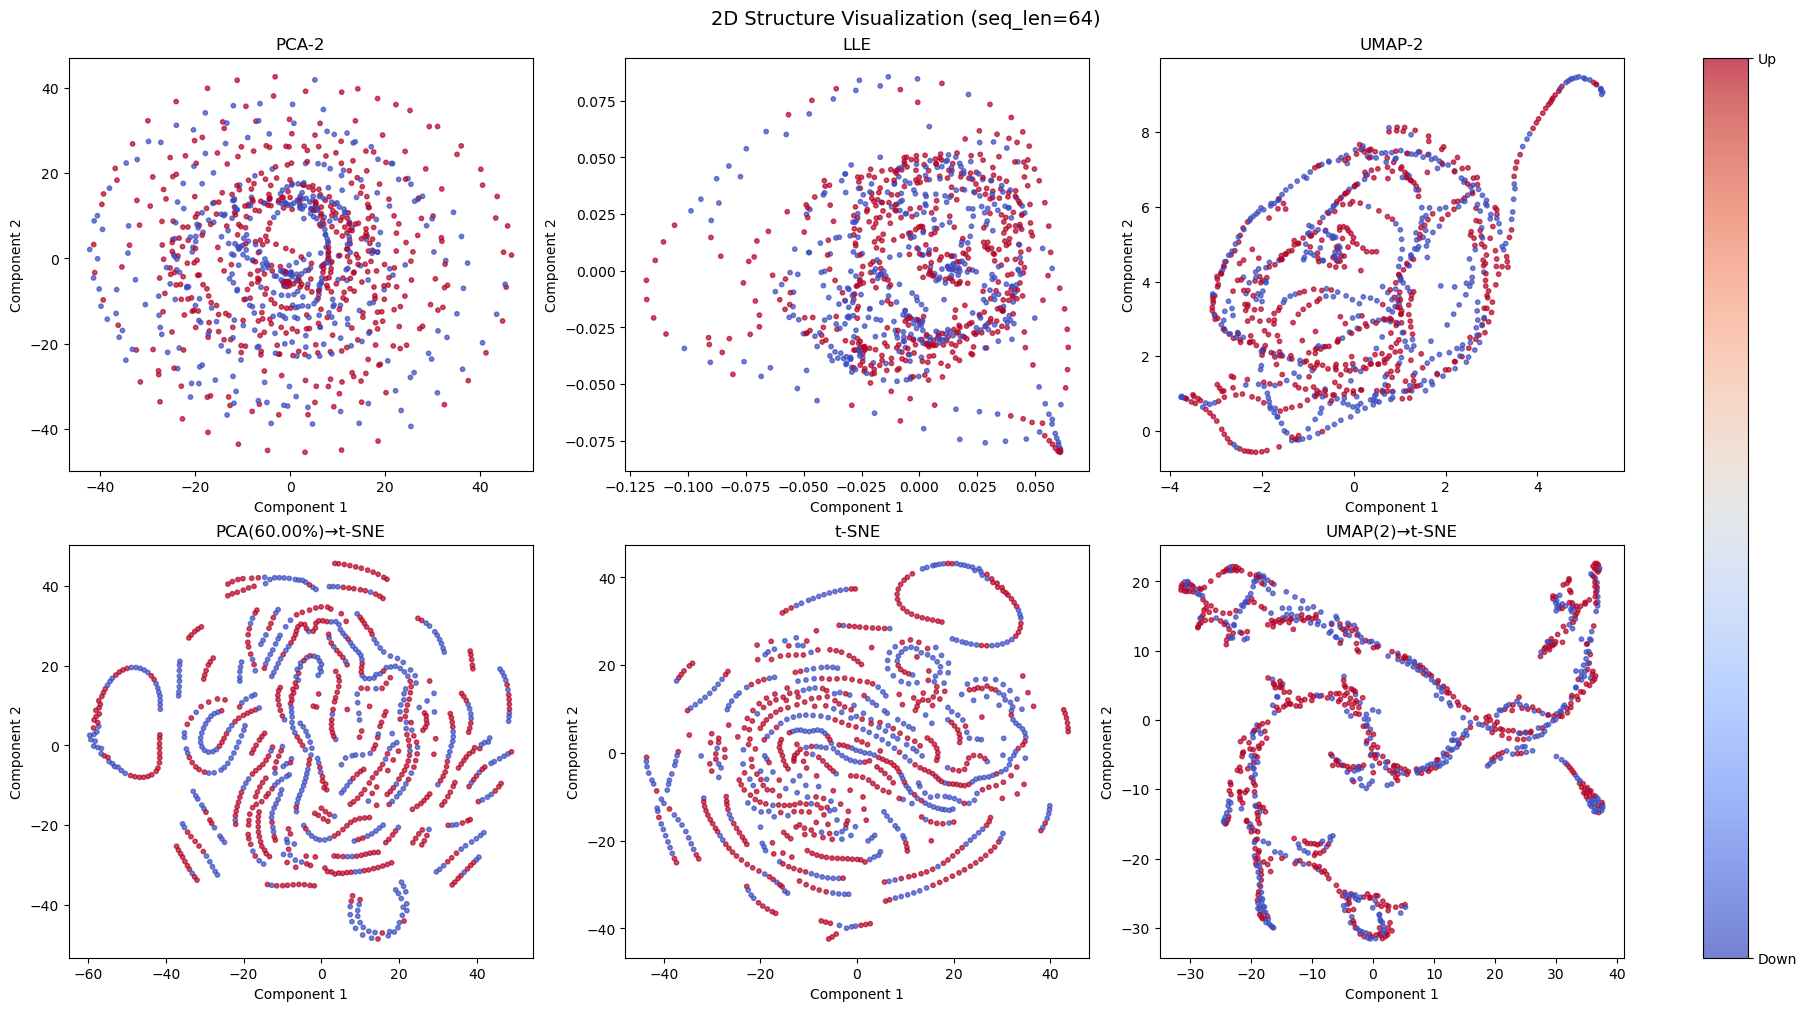

In [5]:
finfact.visualize_structure_2d (seq_len=64,
                                perplexity=30,
                                n_neighbors=10,
                                random_state=42,
                                pca_evp=0.6,
                                umap_components=2
                                )

Clustering eval: 100%|██████████| 18/18 [00:06<00:00,  2.85it/s]


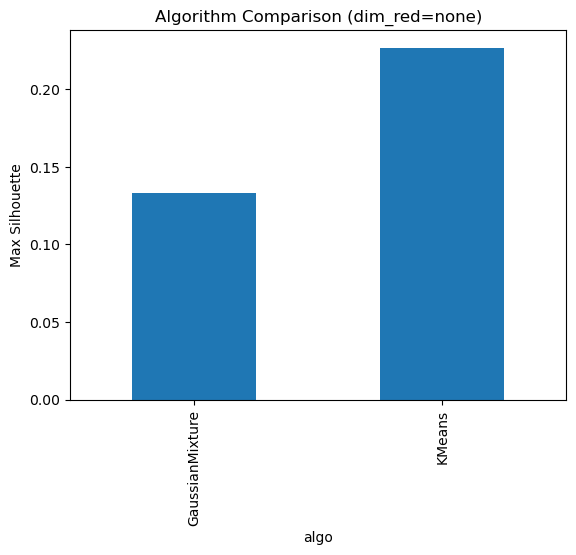

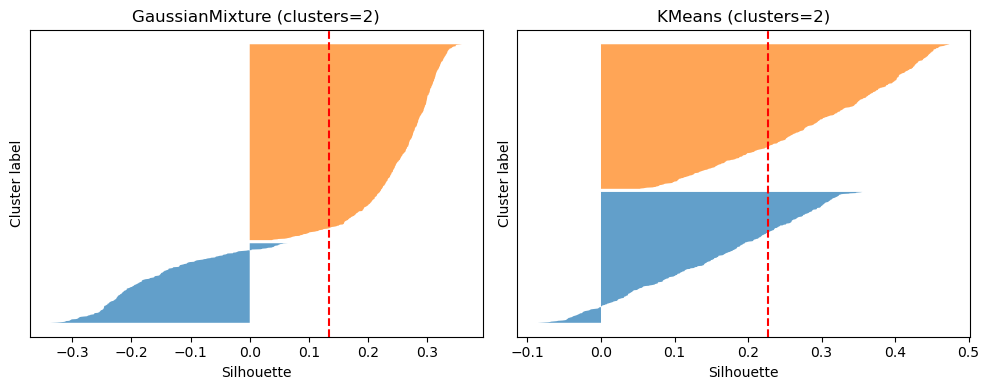

              algo  n_clusters  silhouette
0           KMeans         2.0    0.226706
1  GaussianMixture         NaN    0.133274
2           KMeans         5.0    0.159432
3           KMeans         7.0    0.129569
4           KMeans         6.0    0.139854
5           KMeans         3.0    0.200277
6           KMeans        10.0    0.126677
7           KMeans         4.0    0.173593


In [6]:
cluster_df = finfact.evaluate_clusterings(algos=['KMeans','GaussianMixture'],
                                          metrics=['silhouette'],
                                          seq_len=1)
print(cluster_df[['algo','n_clusters','silhouette']].head(8))

In [ ]:
df_eval_report

In [ ]:
best_row = df_eval_report.loc[12]

In [ ]:
label_series = pd.Series(best_row['_labels'])
counts = label_series.value_counts()
print(counts)

#### IC分析

#### 相关性检测

In [ ]:
df_filtered = finfact.df_features.set_index('timestamp')

In [ ]:
corr = pd.DataFrame (df_filtered).corr ()
plt.figure (figsize=(12, 10))
sns.heatmap (corr, cmap='coolwarm', center=0)
plt.title ('Feature Correlation Matrix')
plt.show ()

#### PCA分析

In [ ]:
from sklearn.decomposition import PCA

pca = PCA ()
pca.fit (df_filtered)
percent = 0.99

cumulative = np.cumsum (pca.explained_variance_ratio_)
n_PCs = np.argmax (cumulative >= percent) + 1

print (f"前 {n_PCs} 个主成分累计解释了 {cumulative[n_PCs - 1]:.2%} 的方差")
feature_names = df_featured.columns

# 打印所有有重大贡献的主成分
for i in range (n_PCs):
    # 第 i 个主成分的系数
    pc = pca.components_[i]

    # 取绝对值最大的特征位置
    top_feature_idx = np.argmax (np.abs (pc))
    top_feature_name = feature_names[top_feature_idx]

    print (f"PC{i + 1} 的主导因子是: {top_feature_name}（贡献系数: {pc[top_feature_idx]:.4f}）")